# Results for the paper: Multi-time quantum process tomography on a superconducting qubit. 

In [13]:
# MIT License

# Copyright (c) [year] [fullname]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [46]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import picos as pic
from os.path import dirname, join as pjoin
import scipy.io as sio
from qutip import *
from qutip.qip.operations import rx, ry, rz, rotation
import scipy.io
import plotly.graph_objects as go
import pandas as pd
from itertools import permutations, combinations_with_replacement
import itertools as it
from os.path import dirname, join as pjoin
import json
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import multinomial, entropy
import copy
import pickle
from numpy import e, real, sort, sqrt, log2, log
#from scipy import log
# from qutip.qobj import ptrace
# from qutip.states import ket2dm
# from qutip.tensor import tensor
# from qutip.operators import sigmay
from qutip.sparse import sp_eigs
# from qutip.qip.operations import cnot, swap
from tabulate import tabulate
from scipy.io import savemat, loadmat
import os
sns.set()

In [15]:
# define useful stuff
xp = (qutip.basis(2, 0) + (1+0j)*qutip.basis(2, 1)).unit()
xm = (qutip.basis(2, 0) - (1+0j)*qutip.basis(2, 1)).unit()
yp = (qutip.basis(2, 0) + (0+1j)*qutip.basis(2, 1)).unit()
ym = (qutip.basis(2, 0) - (0+1j)*qutip.basis(2, 1)).unit()
zp = (qutip.basis(2, 0) + (0+0j)*qutip.basis(2, 1)).unit()
zm = (qutip.basis(2, 1) + (0+0j)*qutip.basis(2, 1)).unit()
basisx = [xp, xm]
basisy = [yp, ym]
basisz = [zp, zm]
I2 = qeye(2)
sigplus = Qobj([[0,1],[0,0]])
sigminus = Qobj([[0,0],[1,0]])
states = [xp, xm, yp, ym, zp, zm]
rhos = [xp*xp.dag(), xm*xm.dag(), yp*yp.dag(), ym*ym.dag(), zp*zp.dag(), zm*zm.dag()]
sigs = [sigmax(), sigmay(), sigmaz(), qeye(2)]

In [16]:
# For the simulation part.

def choi(U):
    "Inputs: a 2-qubit Unitary as a quantum object. \
    Outputs: its Choi as a quantum object. \
    Note: definition is without the transposition.\
    The .trans() below refers to (tensor(U,I2)*bellstate).proj() == (tensor(I2,U.trans())*bellstate).proj()"
    U = U.trans()
    output = U.data.toarray().reshape(U.shape[0]*U.shape[1])
    output = Qobj(output)
    output = output.proj()
    output.dims = [[2,2,2,2],[2,2,2,2]]
#     lives on memory_in, system_in, memory_out, system_out
    return output

def Hamiltonian(w1,w2,g12):
    "Inputs: w1, w2, g12 parameters\
    Outputs: the Hamiltonian as a quantum object"
#     first qubit is memory with w2, second is system
    return ((w2/2)*tensor(sigmaz(),I2) + (w1/2)*tensor(I2,sigmaz()) 
        + g12*(tensor(sigplus,sigminus) + tensor(sigminus, sigplus)))

def Evol(H,t):
    "Inputs: H, t\
    Outputs: the evolution Unitary as a quantum object"
    #     first qubit is memory, second is system
    k = -1j*t*H
    return k.expm()

def Wparam(w1,w2,g12,t1,t2):
    "Inputs: resonance freq of qubit w1 (sys), w2 (mem), coupling g12, and evolution times t1,t2\
    Outputs: the process matrix AoBiBoCi as a quantum object with dims=[[2,2,2,2],[2,2,2,2]]"
    Ham = Hamiltonian(w1,w2,g12)
    U1 = Evol(Ham,t1)
    U2 = Evol(Ham,t2)
    ket0 = basis(2,0) # 1 0 
    ket1 = basis(2,1) # 0 1
    T1 =  tensor(qeye(2),ket0.proj().trans(),qeye(32))# System E1 starts at ket0 state. It's a preparation, hence the .trans().
    T2 =  tensor(choi(U1).permute([1,0,3,2]),qeye(8))# choi(U1) on E1AoE2Bi  
    T3 = tensor(qeye(8),partial_transpose(choi(U2),[1,0,0,0]).permute([0,1,3,2])) # choi(U2) on E2BoE3Ci
    # Re-set dims, to be able to multiply them
    T1.dims = [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
    T2.dims = [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
    T3.dims = [[2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2]]
    whole_process = T3*T2*T1
    W = whole_process.ptrace([0,2,4,5])
    W.dims=[[2,2,2,2],[2,2,2,2]] # make the process into a bipartite state
    return W

In [17]:
# Functions to take the experimental data and calculate the process matrices.
def exp2probs(raw, runlabel):
    ''' Inputs: name of the tomography file and '97,97'. Creates tomo data from Tyler's data
    Reads in data in form 
    {"xp,x,xp,x": {"00": 7917, "01": 13, "10": 31, "11": 29} ...
    and generates tomography data in form
    (0, 0, 0, 0) 0.9908635794743429 '''
    Km = {'x0':0,'x1':1,'y0':2,'y1':3,'z0':4,'z1':5}
    Ks = {'xp':0,'xm':1,'yp':2,'ym':3,'zp':4,'zm':5}
    labels=[]
    probs=[]
    data = raw[runlabel]
    for key in data:
        counts = data[key]
        keys=key.split(',')
        # e.g. keys = ['xp','y','yp','z']
        # e.g. counts looks like {"00": 7917, "01": 13, "10": 31, "11": 29}
        #tot=0
        #for c in counts.values():
        #    tot+=c
        tot = counts['00']+counts['01']+counts['10']+counts['11']
        for l1,l2 in ['00','01','10','11']:# l1,l2 is the first & second number in 'xx'
            lab= (Ks[keys[0]], Km[keys[1]+l1], Ks[keys[2]], Km[keys[3]+l2])
            # key = ('xp','y0','yp','z0') -> (0,2,2,4) = lab
            prob = counts[l1+l2]/tot 
            labels.append(lab)
            probs.append(prob)
    return pd.DataFrame(probs,index=labels)

In [18]:
def exp_runs(tomo,p1,m1,p2,m2):
    "Given the tomo data for a single exp. run, extracts the prob from the dataframe."
    return tomo.loc[[(p1, m1, p2, m2)]][0][0]

In [19]:
def exp_val_ss(tomo, state1,ms1,state2,ms2):
    "Inputs: states1,2 are the preparation states [0,5] and ms1,2 is measurement sigmas [0,3]"
#     This creates the four terms for each preparation states p1,p2.
# <i,j,k,l> = p(j+l+|i+k+) - p(j+l-|i+k+) - p(j-l+|i+k+) + p(j-l-|i+k+) - term 2_i+k- - term3_i-k+ + term4_i+k+
    c = [[0,1],[2,3],[4,5],[4,5]]  # [[xp,xm],[yp,ym],[zp,zm],[zp,zm]] corresponding to measurement outcomes
    r1 = exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][0]) \
    - exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][1]) \
    - exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][0]) \
    + exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][1])
#     if ms1 = 3 (I2)
    r2 = exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][0]) \
    - exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][1]) \
    + exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][0]) \
    - exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][1])
#     if ms2 = 3 (I2)
    r3 = exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][0]) \
    + exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][1]) \
    - exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][0]) \
    - exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][1])
#     if ms1==ms2==3
    r4 = exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][0]) \
    + exp_runs(tomo, state1, c[ms1][0], state2, c[ms2][1]) \
    + exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][0]) \
    + exp_runs(tomo, state1, c[ms1][1], state2, c[ms2][1])
    if ms1==3:
        if ms2==3:
            output = r4
        else:
            output = r2
    if ms2==3:
        if ms1==3:
            output = r4
        else:
            output = r3
    if ms1!=3 and ms2!=3:
        output = r1
    return output

In [20]:
def exp_val_sigmas(tomo,*args):
#      args = ps1,ms1,ps2,ms2
    "Inputs: [0,3] for ps1,ms1,ps2,ms2 corresponding to sigma terms on each witness term"
    tomo = tomo
    ps1 = args[0]
    ms1 = args[1]
    ps2 = args[2]
    ms2 = args[3]
    
#    This generates the four larger terms, total of 16 terms for each case <i,j,k,l>
    c = [[0,1],[2,3],[4,5],[4,5]]  # [[xp,xm],[yp,ym],[zp,zm],[zp,zm]] corresponding to preparing the states
# if ps1 and ps3 are not 3 (identity)
    r1 = exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][0],ms2)\
    - exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][1],ms2)\
    - exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][0],ms2)\
    + exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][1],ms2)
#     if ps1 == 3 (identity)
    r2 = exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][0],ms2)\
    - exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][1],ms2)\
    + exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][0],ms2)\
    - exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][1],ms2)
#     if ps2 == 3 (identity)
    r3 = exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][0],ms2)\
    + exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][1],ms2)\
    - exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][0],ms2)\
    - exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][1],ms2)
#     if ps1 == ps2 == 3 (identity)
    r4 = exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][0],ms2)\
    + exp_val_ss(tomo, c[ps1][0],ms1,c[ps2][1],ms2)\
    + exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][0],ms2)\
    + exp_val_ss(tomo, c[ps1][1],ms1,c[ps2][1],ms2)
    
    if ps1==3:
        if ps2==3:
            output = r4
        else:
            output = r2
    if ps2==3:
        if ps1==3:
            output = r4
        else:
            output = r3
    if ps1!=3 and ps2!=3:
        output = r1
    return output

In [21]:
# Getting the physical Ws.

# Define partial trace constraints
#     LVW =  W + CI(W,dims) - BOCI(W,dims) + BIBOCI(W,dims) - AOBIBOCI(W,dims);
def LC1(W):
    return pic.partial_trace(W, subsystems=(3), dimensions=(2, 2, 2, 2)) @ np.eye(2) / 2

def LB2C1(W):
    return pic.partial_trace(W, subsystems=(2, 3), dimensions=(2, 2, 2, 2)) @ np.eye(4) / 4

def LB1B2C1(W):
    return pic.partial_trace(W, subsystems=(1, 2, 3), dimensions=(2, 2, 2, 2)) @ np.eye(8) / 8

def LA2B1B2C1(W):
    return pic.partial_trace(W, subsystems=(0, 1, 2, 3), dimensions=(2, 2, 2, 2)) @ np.eye(16) / 16

# Finding physical process matrix using SDP
def physical_W_pic(Wexp):
    """
    Find the closest physical process matrix to Wexp using SDP.

    Args:
        Wexp (np.ndarray): Experimental process matrix.

    Returns:
        np.ndarray: Optimized physical process matrix.
    """
    # Constants
    Wexp = pic.Constant('Wexp', Wexp)

    # Variables
    W = pic.HermitianVariable('W', (16, 16))  # Hermitian matrix variable

    # Problem Definition
    P = pic.Problem()

    # Constraints
#     P.add_constraint(LC1(W) == LB2C1(W))
#     P.add_constraint(LB1B2C1(W) == LA2B1B2C1(W))
    
    P.add_constraint(LC1(W) - LA2B1B2C1(W) == LB2C1(W) - LB1B2C1(W))
    P.add_constraint(W >> 0)  # Positive semidefiniteness
    P.add_constraint(pic.trace(W) == 4)  # Trace normalization

    # Objective: Minimize Frobenius norm squared
    frobenius_norm_squared = pic.sum(
        ((Wexp[i, j].real - W[i, j].real) ** 2 + (Wexp[i, j].imag - W[i, j].imag) ** 2)
        for i in range(16) for j in range(16)
    )
    P.set_objective("min", frobenius_norm_squared)

    # Solve the SDP
    P.solve(solver="cvxopt")

    # Return the optimized process matrix as a numpy array
    return np.array(W.value)  # Use .value to extract the optimized value


In [33]:
def neg(W):
    "inputs W as an array and turns it into Qobj of 4, 4 state \
    takes PPT, one for each system and finds the Negativity, sum of neg eigs."
    W = Qobj(W, dims = [[4,4],[4,4]])
    eigs1 = partial_transpose(W,[1,0]).eigenenergies() # Transpose 1st system
    eigs2 = partial_transpose(W,[0,1]).eigenenergies()
    sum_eigs1 = sum([num for num in eigs1 if num < 0])
    sum_eigs2 = sum([num for num in eigs2 if num < 0])
    return abs(min([sum_eigs1,sum_eigs2]))

In [23]:
# Better functions for entropy, for simulated data to avoid infinities.
def entropy_vn(rho, base=e, sparse=False):
    """
    Von-Neumann entropy of density matrix

    Parameters
    ----------
    rho : qobj
        Density matrix.
    base : {e,2}
        Base of logarithm.
    sparse : {False,True}
        Use sparse eigensolver.

    Returns
    -------
    entropy : float
        Von-Neumann entropy of `rho`.

    Examples
    --------
    >>> rho=0.5*fock_dm(2,0)+0.5*fock_dm(2,1)
    >>> entropy_vn(rho,2)
    1.0

    """
    if rho.type == 'ket' or rho.type == 'bra':
        rho = ket2dm(rho)
    vals = sp_eigs(rho.data, rho.isherm, vecs=False, sparse=False)
    #nzvals = vals[vals != 0]
    nzvals = vals[vals > 0.0001]
    if base == 2:
        logvals = log2(nzvals)
    elif base == e:
        logvals = log(nzvals)
    else:
        raise ValueError("Base must be 2 or e.")
    return float(real(-sum(nzvals * logvals)))

def _entropy_relative(rho, sigma, base=e, sparse=False):
    """
    ****NEEDS TO BE WORKED ON**** (after 2.0 release)
    C. G. : fixed the problem, some zeros were not removed because they were 0.0000.

    Calculates the relative entropy S(rho||sigma) between two density
    matrices..

    Parameters
    ----------
    rho : qobj
        First density matrix.
    sigma : qobj
        Second density matrix.
    base : {e,2}
        Base of logarithm.

    Returns
    -------
    rel_ent : float
        Value of relative entropy.

    """
    if rho.type != 'oper' or sigma.type != 'oper':
        raise TypeError("Inputs must be density matrices..")
    # sigma terms
    svals = sp_eigs(sigma.data, sigma.isherm, vecs=False, sparse=False) # returns eigenvalues of sigma (C.G.).
#     snzvals = svals[svals != 0] # EDIT: 0 is not enough to remove 0.000. C.G.
    snzvals = svals[svals > 0.0001]
    if base == 2:
        slogvals = log2(snzvals)
    elif base == e:
        slogvals = log(snzvals)
    else:
        raise ValueError("Base must be 2 or e.")
    # rho terms
    rvals = sp_eigs(rho.data, rho.isherm, vecs=False, sparse=sparse)
#     rnzvals = rvals[rvals != 0] # Same edit as above. C.G.
    rnzvals = svals[svals > 0.0001]
    # calculate tr(rho*log sigma)
    rel_trace = float(real(sum(rnzvals * slogvals)))
    return -entropy_vn(rho, base, sparse) - rel_trace

In [24]:
# Read the exp. data.
with open('NMN_tomog_rerun.json') as fp:
    raw_data_ibm = json.load(fp)
    
with open('NMN_lab_rslts.json') as fp:
    raw_data_uq = json.load(fp)

In [25]:
tomo_uq = exp2probs(raw_data_uq,'97,97')

In [26]:
# basis_w: Basis is the pauli for both states and measurements.
# The preparations are with a transpose (due to Choi).
# Wmeasure: has all the sigma elements for tomo. (0,0,2,2)
# corresp_list: = Wmeasure with an index b = 0,1,2,3,... in front.
N = 2*2*4*2*2*4
corresp_list = []
Wmeasure = []
basis_w = np.zeros((N,16,16), dtype = complex)
b = 0
for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                basis_w[l + 4*(k + 4*(j + 4*(i)))] = tensor(sigs[i].trans(), sigs[j], sigs[k].trans(), sigs[l]).full()
                corresp_list.append([b,i,j,k,l])
                Wmeasure.append([i,j,k,l])
                b+=1        
#                 print(l + 4*(k + 4*(j + 4*(i))), i, j, k, l )

In [27]:
# The process matrix (unphysical) of UQ. The IBM case will be automated later.
W_exp_uq = [0]
for i in range(len(basis_w)):
    W_exp_uq +=(1/16)* exp_val_sigmas(tomo_uq,*Wmeasure[i])*basis_w[i]

In [28]:
# W physical for UQ (takes a few seconds)
W_physUQ = physical_W_pic(W_exp_uq)

In [29]:
W_ph_UQ = Qobj(W_physUQ, dims = [[2,2,2,2],[2,2,2,2]])
W_M_UQ = tensor(ptrace(W_ph_UQ,[0,1]), ptrace(W_ph_UQ,[2,3]))/4 # because each term has trace 4

In [34]:
neg_uq = neg(W_physUQ/4) # normalised to be a state
rel_uq = entropy_relative(W_ph_UQ/4, W_M_UQ/4)

In [36]:
# Automate process for IBM data.
'''
Select source as 'uq' or 'ibm'
One (for uq) or nine (for ibm) experimental process matrices will be saved 
'''

#--------------------------------------
source = 'ibm' #'ibm'
#--------------------------------------


if source == 'uq':
    raw_data = raw_data_uq
elif source == 'ibm':
    raw_data = raw_data_ibm
else:
    raise RuntimeError('choose source to be uq or ibm')

W_exps = {}
for key in raw_data.keys():
    tomo = exp2probs(raw_data, key)
    new_key = key[:2] + key.split(',')[1][:2]
    W_exp = [0]
    for i in range(len(basis_w)):
        W_exp += (1/16)* exp_val_sigmas(tomo,*Wmeasure[i])*basis_w[i]
    W_exps[f'Wexp_{source}_{new_key}'] = W_exp
# W_exps['Wexp_uq_9797'] = Wexp_uq_9797 # for UQ

In [37]:
W_exps['Wexp_uq_9797'] = W_exp_uq # add the uq one to the W_exps

In [40]:
# Get the physical Ws and the Markovian ones and the metrics.
W_ph = [0]
negs = []
rels = []
W_M = [0]
W_phs = {}
W_ms = {}
for key in W_exps.keys():
    source = 'ibm'
    new_key = key[9:]
    W_ph = physical_W_pic(W_exps[key])
    W_ph_q = Qobj(W_ph, dims = [[2,2,2,2],[2,2,2,2]])
    W_M = tensor(ptrace(W_ph_q,[0,1]), ptrace(W_ph_q,[2,3]))/4 # because each term has trace 4
    W_phs[f'Wph_{source}_{new_key}'] = W_ph # save the physicals.
    W_ms[f'Wm_{source}_{new_key}'] = W_M.full() # save the Markovians.
    negs.append(neg(W_ph/4))
    rels.append(entropy_relative(W_ph_q/4, W_M/4))
# add the uq metrics
negs.append(neg_uq) 
rels.append(rel_uq)    

In [41]:
# Add the uq process matrices to the saved matrices.
W_phs[f'Wph_uq_9797'] = W_physUQ # add the uq W phys
W_ms[f'Wm_uq_9797'] = W_M_UQ.full() # add the Markovian W uq (Qobj)

In [42]:
# save the Ws experimental, physical and Markovian.
os.makedirs('Ws', exist_ok = True)
savemat(f'Ws/Wexp_all.mat', W_exps)
savemat(f'Ws/Wphys_all.mat', W_phs)
savemat(f'Ws/Wmark_all.mat', W_ms)

In [43]:
np.save('Ws/negs.npy', negs)
np.save('Ws/rels.npy', rels)

In [76]:
# All metrics as shown in the paper.
uq_keys= list(raw_data_uq.keys())
ibm_keys = list(raw_data_ibm.keys())

# Sample data as a list of lists
data_metrics = [
    ["UQ",uq_keys[0], rels[9], negs[9]],
    ["IBM", ibm_keys[0], rels[0], negs[0] ],
    ["IBM", ibm_keys[1], rels[1], negs[1] ],
    ["IBM", ibm_keys[2], rels[2], negs[2] ],
    ["IBM", ibm_keys[3], rels[3], negs[3] ],
    ["IBM", ibm_keys[4], rels[4], negs[4] ],
    ["IBM", ibm_keys[5], rels[5], negs[5] ],
    ["IBM", ibm_keys[6], rels[6], negs[6] ],
    ["IBM", ibm_keys[7], rels[7], negs[7] ],
    ["IBM", ibm_keys[8], rels[8], negs[8] ]
]

# Define headers for the table
headers = ["Processor","Evolution times", "Relative Entropy", "Negativity"]

# Print the table with a grid format
print(tabulate(data_metrics, headers=headers, tablefmt="grid"))

# You can also choose other formats, e.g., "pretty", "simple", "pipe"
# print(tabulate(data, headers=headers, tablefmt="pretty"))

+-------------+-------------------+--------------------+--------------+
| Processor   | Evolution times   |   Relative Entropy |   Negativity |
+=============+===================+====================+==============+
| UQ          | 97,97             |          0.230118  |   0.0216575  |
+-------------+-------------------+--------------------+--------------+
| IBM         | 21.333,21.333     |          0.042558  |   0.0040224  |
+-------------+-------------------+--------------------+--------------+
| IBM         | 21.333,24.889     |          0.0360879 |   0.00414949 |
+-------------+-------------------+--------------------+--------------+
| IBM         | 21.333,28.444     |          0.0434772 |   0.00554525 |
+-------------+-------------------+--------------------+--------------+
| IBM         | 24.889,21.333     |          0.0335228 |   0.00485666 |
+-------------+-------------------+--------------------+--------------+
| IBM         | 24.889,24.889     |          0.0460997 |   0.004

## Cityscape of 4 process matrices

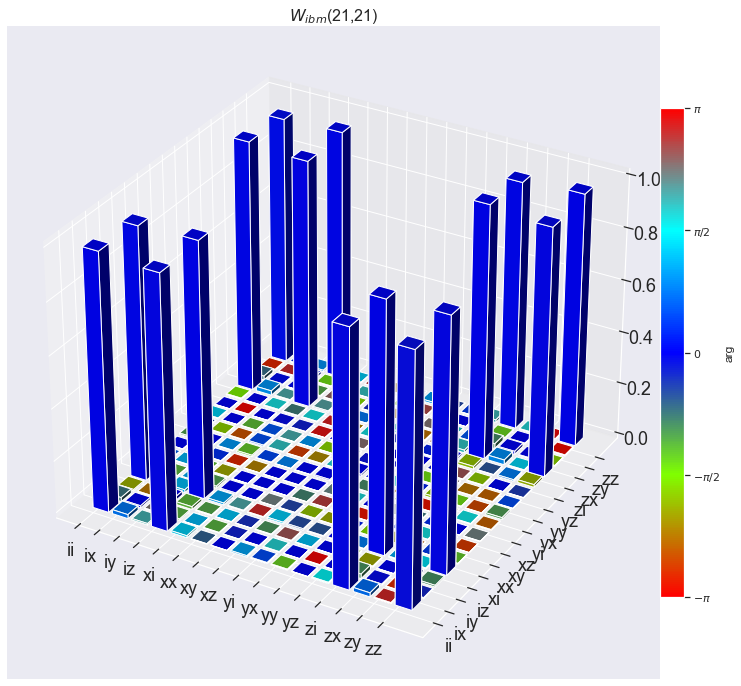

In [94]:
# Plot IBM

W_ibm = Qobj(W_phs['Wph_ibm_2121'], dims = [[2,2,2,2],[2,2,2,2]])
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
# chi = qpt(U_rho, op_basis)

# Correct unpacking
fig, ax = qpt_plot_combined(W_ibm, op_label, figsize=(14,12)) #r'$i$SWAP'


# Directly set z-axis
ax.set_zlim(0, 1)
# ax.set_zlabel('Absolute value of entry')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_title('$W_{ibm}$(21,21)', fontsize=16)

plt.show()

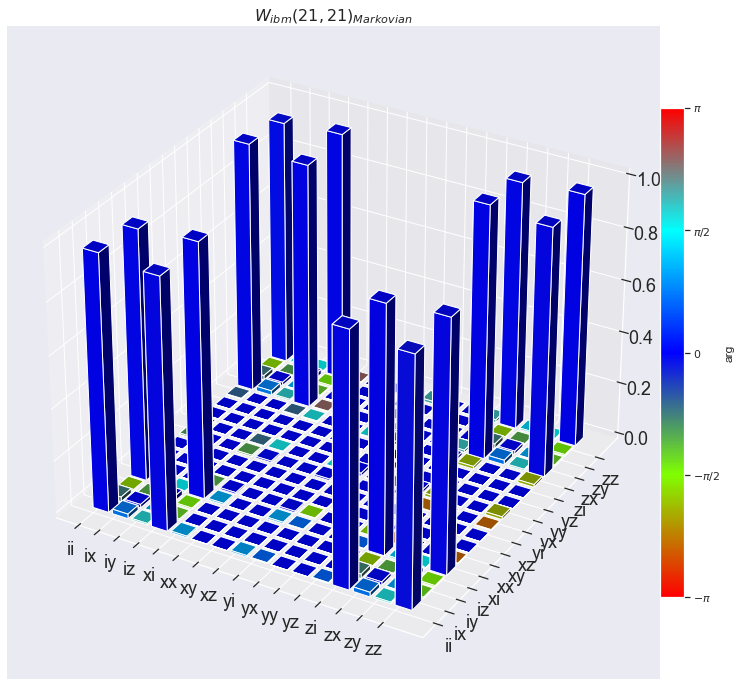

In [95]:
# Plot the markovian IBM
W_ibm_m = Qobj(W_ms['Wm_ibm_2121'], dims = [[2,2,2,2],[2,2,2,2]])
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
# chi = qpt(U_rho, op_basis)

# Correct unpacking
fig, ax = qpt_plot_combined(W_ibm_m, op_label, 'W_ibm_Markovian', figsize=(14, 12))

# Directly set z-axis
ax.set_zlim(0, 1)
# ax.set_zlabel('Absolute value of entry')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_title('$W_{ibm}(21,21)_{Markovian}$', fontsize=16)



plt.show()

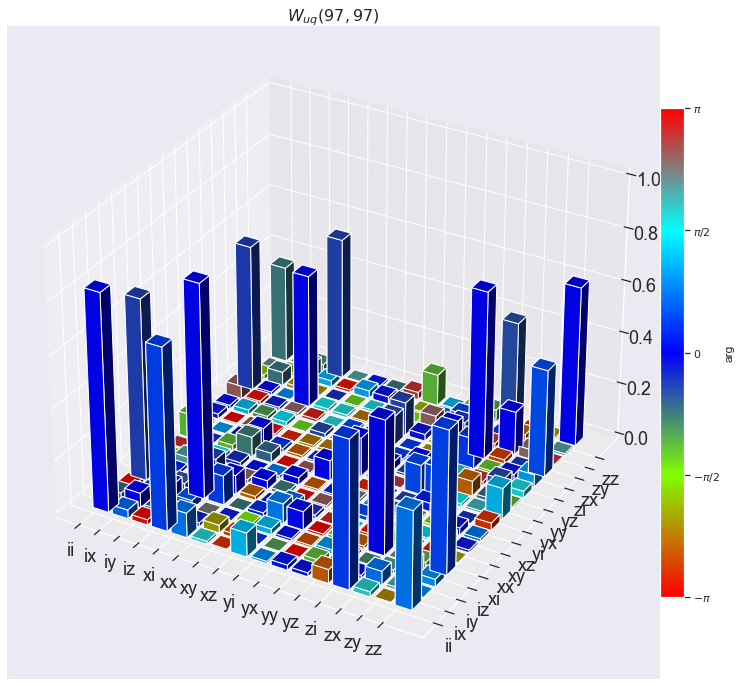

In [96]:
# Plot the UQ
W_uq = Qobj(W_phs['Wph_uq_9797'], dims = [[2,2,2,2],[2,2,2,2]])
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
# chi = qpt(U_rho, op_basis)

# Correct unpacking
fig, ax = qpt_plot_combined(W_uq, op_label, 'W_uq', figsize=(14, 12))


# Directly set z-axis
ax.set_zlim(0, 1)
# ax.set_zlabel('Absolute value of entry')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_title('$W_{uq}(97,97)$', fontsize=16)


plt.show()

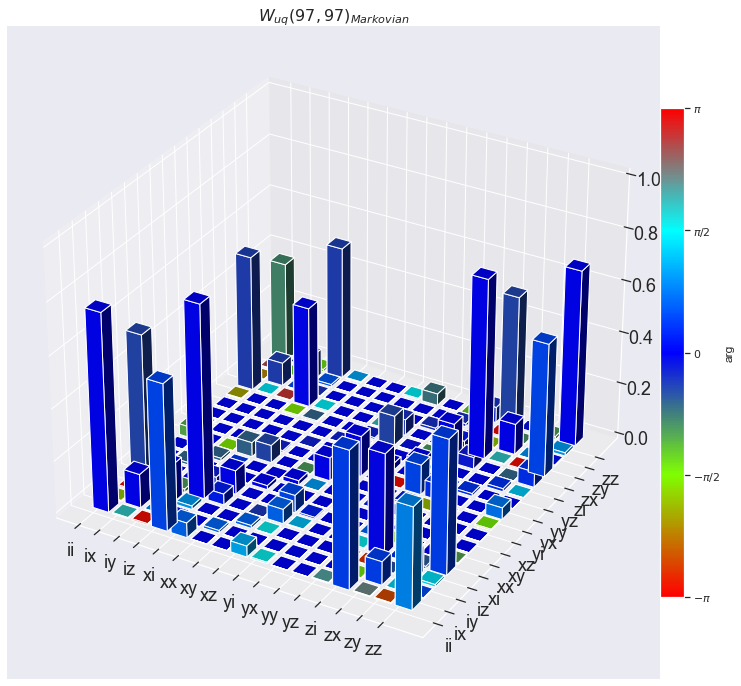

In [97]:
# # Plot the markovian UQ
W_uq_m = Qobj(W_ms['Wm_uq_9797'], dims = [[2,2,2,2],[2,2,2,2]])
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2
# chi = qpt(U_rho, op_basis)

# Correct unpacking
fig, ax = qpt_plot_combined(W_uq_m, op_label, 'W_uq_Markovian', figsize=(14, 12))

# Directly set z-axis
ax.set_zlim(0, 1)
# ax.set_zlabel('Absolute value of entry')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_title('$W_{uq}(97,97)_{Markovian}$', fontsize=16)


plt.show()

In [47]:
#Calculate the metrics for the UQ simulation.
neg_uq = []  
rel_uq = []
w1_ibm = 2*np.pi*5.11 # system 
w2_ibm = 2*np.pi*5.03 # memory
g12_ibm = 2*np.pi*0.011
t_ibm = np.linspace(84,100,100)
for t1 in t_ibm:
    for t2 in t_ibm:
        a = Wparam(w1_ibm,w2_ibm,g12_ibm,t1,t2)
        neg_uq.append(neg(a/4))
        a_m = tensor(ptrace(a,[0,1]), ptrace(a,[2,3]))/4 
        rel_uq.append(_entropy_relative(a/4,a_m/4))

In [48]:
#Calculate the metrics for the IBM simulation.
neg_ibm = []  
rel_ibm = []
w1_ibm = 2*np.pi*5.16 
w2_ibm = 2*np.pi*4.98
g12_ibm = 2*np.pi*0.003
t_ibm = np.linspace(17,33,100)
for t1 in t_ibm:
    for t2 in t_ibm:
        a = Wparam(w1_ibm,w2_ibm,g12_ibm,t1,t2)
        neg_ibm.append(neg(a/4))
        a_m = tensor(ptrace(a,[0,1]), ptrace(a,[2,3]))/4 
        rel_ibm.append(_entropy_relative(a/4,a_m/4))

In [49]:
# Measured and simulated (max) metrics

rels_ibm = rels[:9]
negs_ibm = negs[:9]
# Sample data as a list of lists
data = [
    ["UQ","Measured", max(rels), max(negs)],
    ["UQ", "Simulated", max(rel_uq), max(neg_uq)],
    ["IBM", "Measured", max(rels_ibm), max(negs_ibm) ],
    ["IBM", "Simulated", max(rel_ibm), max(neg_ibm) ]
]

# Define headers for the table
headers = ["Processor","Measured/Simulated", "Relative Entropy", "Negativity"]

# Print the table with a grid format
print(tabulate(data, headers=headers, tablefmt="grid"))

# You can also choose other formats, e.g., "pretty", "simple", "pipe"


+-------------+----------------------+--------------------+--------------+
| Processor   | Measured/Simulated   |   Relative Entropy |   Negativity |
+=============+======================+====================+==============+
| UQ          | Measured             |        0.230118    |  0.0216575   |
+-------------+----------------------+--------------------+--------------+
| UQ          | Simulated            |        0.0613704   |  0.0229834   |
+-------------+----------------------+--------------------+--------------+
| IBM         | Measured             |        0.0560668   |  0.00609289  |
+-------------+----------------------+--------------------+--------------+
| IBM         | Simulated            |        0.000767168 |  0.000343269 |
+-------------+----------------------+--------------------+--------------+


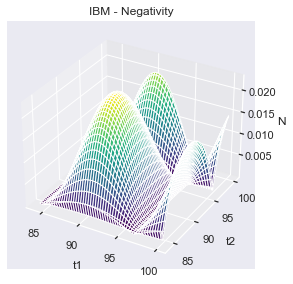

In [58]:
# Negativity UQ
# Generate 100 points in the x and y axes
x = np.linspace(84, 100, 100)
y = np.linspace(84, 100, 100)

# Create a grid of x and y values
x, y = np.meshgrid(x, y)

# Define a function of x and y
z = neg_uq
z = np.array(z)
z = z.reshape((100,100))
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, cmap='viridis')

# Add labels
ax.set_xlabel('t1')
ax.set_ylabel('t2')
ax.set_zlabel('N')
ax.set_title('IBM - Negativity')

# Show the plot
# plt.savefig('IBM - Negativity')
plt.tight_layout()
plt.show()

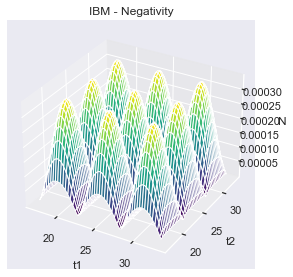

In [56]:
# Negativity IBM
# Generate 100 points in the x and y axes
x = np.linspace(17, 33, 100)
y = np.linspace(17, 33, 100)

# Create a grid of x and y values
x, y = np.meshgrid(x, y)

# Define a function of x and y
z = neg_ibm
z = np.array(z)
z = z.reshape((100,100))
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, cmap='viridis')

# Add labels
ax.set_xlabel('t1')
ax.set_ylabel('t2')
ax.set_zlabel('N')
ax.set_title('IBM - Negativity')

# Show the plot
# plt.savefig('IBM - Negativity')
plt.tight_layout()
plt.show()


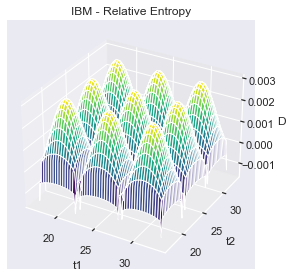

In [52]:
# Relative Entropy IBM
# Generate 100 points in the x and y axes
x = np.linspace(17, 33, 100)
y = np.linspace(17, 33, 100)

# Create a grid of x and y values
x, y = np.meshgrid(x, y)

# Define a function of x and y
z = rel_ibm
z = np.array(z)
z = z.reshape((100,100))
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, cmap='viridis')

# Add labels
ax.set_xlabel('t1')
ax.set_ylabel('t2')
ax.set_zlabel('D')
ax.set_title('IBM - Relative Entropy')

# Show the plot
# plt.savefig('IBM - Relative Entropy')
plt.tight_layout()
plt.show()

# Errors with bootstrapping - multinomial noise only (sampling error, not measurement error)

In [81]:
# In the paper, we present the metrics from Python (D,N) and the errors from Julia.
# Metrics in python vs Julia: slighly different values due to SDP in Julia vs Python.
# Errors on Python are calculated below to account for the sampling noise. S Err(D/N)
# Errors on Julia are calculated to account for the sampling and measurement noise. S&M Err()
# Below is the table with metrics from Python, errors from Python and errors from Julia.

data_metrics = [
    ["UQ",uq_keys[0], rels[9], negs[9]],
    ["IBM", ibm_keys[0], rels[0], negs[0] ],
    ["IBM", ibm_keys[1], rels[1], negs[1] ],
    ["IBM", ibm_keys[2], rels[2], negs[2] ],
    ["IBM", ibm_keys[3], rels[3], negs[3] ],
    ["IBM", ibm_keys[4], rels[4], negs[4] ],
    ["IBM", ibm_keys[5], rels[5], negs[5] ],
    ["IBM", ibm_keys[6], rels[6], negs[6] ],
    ["IBM", ibm_keys[7], rels[7], negs[7] ],
    ["IBM", ibm_keys[8], rels[8], negs[8] ]
]

# D, Derr, N, Nerr from Julia. 
data_julia = [
    [0.231793,0.00797059,0.0215163,0.00238111],
    [0.0445955,0.0073567,0.00431175,0.00148058],
    [0.0381847,0.00698627,0.00439903,0.0014267],
    [0.047058,0.0075355,0.00572467,0.00173334],
    [0.0364105,0.00683438,0.00528793,0.00161001],
    [0.046707,0.00702403,0.00486606,0.00135989],
    [0.0578932,0.0072954,0.00646514,0.00150875],
    [0.0539945,0.00740851,0.00551006,0.00145897],
    [0.0462329,0.00690381,0.00589261,0.00130359],
    [0.0420877,0.00701419,0.00480866,0.00143875],
]

rel_errors = [0.0060436146658187,
0.009088399801829081,
 0.009054163869561855,
 0.008851734489284079,
 0.008417022650007712,
 0.008323206342096958,
 0.008479836603725619,
 0.008102470869920386,
 0.007736919706689305,
 0.008271079021203163
]
neg_errors = [
 0.0021445799725562623,
 0.0015283683781002002,
 0.0014928186891284743,
 0.0015886870321324936,
 0.0016087338456940426,
 0.0017603628088957634,
 0.0017705464049304648,
 0.0017214205706769872,
 0.001677401215686001,
 0.0015791694333845497    
]
data_all = [
      ["UQ",uq_keys[0], rels[9], rel_errors[0], data_julia[0][1],  negs[9], neg_errors[0], data_julia[0][3]],
    ["IBM", ibm_keys[0], rels[0], rel_errors[1], data_julia[1][1],  negs[0], neg_errors[1], data_julia[1][3] ],
    ["IBM", ibm_keys[1], rels[1], rel_errors[2], data_julia[2][1],  negs[1], neg_errors[2], data_julia[2][3] ],
    ["IBM", ibm_keys[2], rels[2], rel_errors[3], data_julia[3][1],  negs[2], neg_errors[3], data_julia[3][3] ],
    ["IBM", ibm_keys[3], rels[3], rel_errors[4], data_julia[4][1],  negs[3], neg_errors[4], data_julia[4][3] ],
    ["IBM", ibm_keys[4], rels[4], rel_errors[5], data_julia[5][1],  negs[4], neg_errors[5], data_julia[5][3] ],
    ["IBM", ibm_keys[5], rels[5], rel_errors[6], data_julia[6][1],  negs[5], neg_errors[6], data_julia[6][3] ],
    ["IBM", ibm_keys[6], rels[6], rel_errors[7], data_julia[7][1],  negs[6], neg_errors[7], data_julia[7][3] ],
    ["IBM", ibm_keys[7], rels[7], rel_errors[8], data_julia[8][1],  negs[7], neg_errors[8], data_julia[8][3] ],
    ["IBM", ibm_keys[8], rels[8], rel_errors[9], data_julia[9][1],  negs[8], neg_errors[9], data_julia[9][3] ]
]

# Define headers for the table
headers = ["Experiment","D", "S Err(D)","S&M Err(D)", "N", "S Err(N)","S&M Err(N)"]

# Print the table with a grid format
print(tabulate(data_all, headers=headers, tablefmt="grid"))

+-----+---------------+-----------+------------+--------------+------------+------------+--------------+
|     | Expriment     |         D |   S Err(D) |   S&M Err(D) |          N |   S Err(N) |   S&M Err(N) |
+=====+===============+===========+============+==============+============+============+==============+
| UQ  | 97,97         | 0.230118  | 0.00604361 |   0.00797059 | 0.0216575  | 0.00214458 |   0.00238111 |
+-----+---------------+-----------+------------+--------------+------------+------------+--------------+
| IBM | 21.333,21.333 | 0.042558  | 0.0090884  |   0.0073567  | 0.0040224  | 0.00152837 |   0.00148058 |
+-----+---------------+-----------+------------+--------------+------------+------------+--------------+
| IBM | 21.333,24.889 | 0.0360879 | 0.00905416 |   0.00698627 | 0.00414949 | 0.00149282 |   0.0014267  |
+-----+---------------+-----------+------------+--------------+------------+------------+--------------+
| IBM | 21.333,28.444 | 0.0434772 | 0.00885173 |   0.00

In [95]:
### ---------------------------------------------------- #######
### generating UQ metrics for sampled Ws (bootstrapping) #######
### ---------------------------------------------------- #######
# takes around an hour with current parameters

neg_samples = []
rel_samples = []
start = time.time()
for i, (k, W_sample) in enumerate(W_exps_uq.items()):
    W_physUQ_sample = physical_W_pic(W_sample)
    W_ph_UQ_sample = Qobj(W_physUQ_sample, dims = [[2,2,2,2],[2,2,2,2]])
    W_M_UQ_sample = tensor(ptrace(W_ph_UQ_sample,[0,1]), ptrace(W_ph_UQ_sample,[2,3]))/4 # because each term has trace 4
    neg_samples += [neg(W_physUQ_sample/4)]
    rel_samples += [entropy_relative(W_ph_UQ_sample/4, W_M_UQ_sample/4)]
    if (i % 50) == 0:
        print(k, time.time() - start)

Wexp_uq_9797_0 2.884307861328125
Wexp_uq_9797_50 176.21173667907715
Wexp_uq_9797_100 334.0759696960449
Wexp_uq_9797_150 489.4479548931122
Wexp_uq_9797_200 647.9092447757721
Wexp_uq_9797_250 807.4365477561951
Wexp_uq_9797_300 965.7665269374847
Wexp_uq_9797_350 1123.9161357879639
Wexp_uq_9797_400 1280.1221346855164
Wexp_uq_9797_450 1436.170456647873
Wexp_uq_9797_500 1590.3773319721222
Wexp_uq_9797_550 1747.0770297050476
Wexp_uq_9797_600 1901.2546968460083
Wexp_uq_9797_650 2056.3501918315887
Wexp_uq_9797_700 2210.0167858600616
Wexp_uq_9797_750 2357.2607250213623
Wexp_uq_9797_800 2503.882512807846
Wexp_uq_9797_850 2650.0872478485107
Wexp_uq_9797_900 2798.137891769409
Wexp_uq_9797_950 2945.4923017024994


In [114]:
print(np.mean(rel_samples),2*np.std(rel_samples))
rel_uq

(0.23147522221173217-3.693143692438432e-11j) 0.0060436146658187


0.9204702968426949

In [108]:
print(np.mean(neg_samples),2*np.std(neg_samples))
neg_uq

-0.02186343895414702 0.0021445799725562623


-0.021657467974106726

In [ ]:
### ----------------------------------------------- #######
### sampling new ibm Ws with multinomial resampling #######
### ----------------------------------------------- #######
# takes on the order of 18 (!) hours with current parameters

start = time.time()
n = 8000 # num shots
k = 324 # num tomog measurements
g = 1000 # Number of synthetic samples !!
num_cpus = 4 # num cpus for processing

rv_dict = {}

def make_W(m, orig_tomo, rv_dict):
    new_tomo = copy.deepcopy(orig_tomo)
    for i in range(324):
        new_tomo[0][4*i:4*(i+1)] = rv_dict[f'meas{i}'][m] / 8000
    new_W = [0]
    for i in range(len(basis_w)):
        new_W += (1/16) * exp_val_sigmas(new_tomo,*Wmeasure[i])*basis_w[i]
    return new_W

W_exps_ibm_all = {}
for key in raw_data_ibm.keys():
    new_key = key[:2] + key.split(',')[1][:2]
    tomo_ibm = exp2probs(raw_data_ibm,key)# this is tomo!
    for i in range(0,k): # number of rvs
        meas_idx = f'meas{i}'
        mn = multinomial(n,[tomo_ibm[0][4*i+m] for m in range(4)])
        rv_dict[meas_idx] = mn.rvs(g)
    
    W_args = [(m, tomo_ibm, rv_dict) for m in range(g)]
    with Pool(num_cpus) as pool:
        Ws = pool.starmap(make_W, W_args)
    print(time.time() - start)
    W_exps_ibm = {f'Wexp_ibm_{new_key}_{m}': W for m, W in enumerate(Ws)}
    W_exps_ibm_all[f'Wexp_ibm_{new_key}'] = W_exps_ibm

7122.80526304245
14104.852478027344
21152.94341802597


In [ ]:
### ----------------------------------------------------- #######
### generating IBM metrics for sampled Ws (bootstrapping) #######
### ----------------------------------------------------- #######
# takes around 9 hours (!) with current parameters

W_ph = [0]
neg_samples_ibm = {}
rel_samples_ibm = {}
W_M = [0]
W_phs = {}
W_ms = {}
for key in W_exps_ibm_all.keys():
    new_key = key[7:]
    source = 'ibm'
    W_phs[f'Wph_{source}_{new_key}'] = []
    W_ms[f'Wm_{source}_{new_key}'] = []
    neg_samples_ibm[f'{source}_{new_key}'] = []
    rel_samples_ibm[f'{source}_{new_key}'] = []
    for key2 in W_exps_ibm_all[key]:
        W_ph = physical_W_pic(W_exps_ibm_all[key][key2])
        W_ph_q = Qobj(W_ph, dims = [[2,2,2,2],[2,2,2,2]])
        W_M = tensor(ptrace(W_ph_q,[0,1]), ptrace(W_ph_q,[2,3]))/4 # because each term has trace 4
        W_phs[f'Wph_{source}_{new_key}'] += [W_ph] # save the physicals.
        W_ms[f'Wm_{source}_{new_key}'] += [W_M] # save the Markovians.
        neg_samples_ibm[f'{source}_{new_key}'].append(neg(W_ph/4))
        rel_samples_ibm[f'{source}_{new_key}'].append(entropy_relative(W_ph_q/4, W_M/4))
    

In [123]:
### --------------------------------------- #######
###  IBM metric uncertainty (bootstrapping) #######
### --------------------------------------- #######
for key, v in rel_samples_ibm.items():
    print(key, 2*np.std(v))
print('--------')
for key, v in neg_samples_ibm.items():
    print(key, 2*np.std(v))

ibm_m_2121 0.009088399801829081
ibm_m_2124 0.009054163869561855
ibm_m_2128 0.008851734489284079
ibm_m_2421 0.008417022650007712
ibm_m_2424 0.008323206342096958
ibm_m_2428 0.008479836603725619
ibm_m_2821 0.008102470869920386
ibm_m_2824 0.007736919706689305
ibm_m_2828 0.008271079021203163
--------
ibm_m_2121 0.0015283683781002002
ibm_m_2124 0.0014928186891284743
ibm_m_2128 0.0015886870321324936
ibm_m_2421 0.0016087338456940426
ibm_m_2424 0.0017603628088957634
ibm_m_2428 0.0017705464049304648
ibm_m_2821 0.0017214205706769872
ibm_m_2824 0.001677401215686001
ibm_m_2828 0.0015791694333845497
